# Explore here

In [155]:
# Your code here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Paso 1: Importación de los datos

In [156]:
data = pd.read_csv("D:/MARIA/4geeks/modulo12-eda/modulo12-machine-learning-python-template/data/raw/AB_NYC_2019.csv")
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Paso 2: exploración y limpieza de datos

In [157]:
data.shape

(48895, 16)

In [158]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

### Valores nulos
Vemos que tenemos valores nulos en las columnas name, host_name, last_review y reviews_per_month. En las dos primeras solo tenemos 20 valores nulos y en las dos últimas unos 10000 aproximadamente, lo cual representa una falta del 20 % de los datos. 

In [159]:
# Incidencia de los valores perdidos en cada una de las variables.
data.isnull().mean()*100

id                                 0.000000
name                               0.032723
host_id                            0.000000
host_name                          0.042949
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.558339
reviews_per_month                 20.558339
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64

In [160]:
data.drop(columns=['last_review', 'reviews_per_month'], inplace=True) # ELimino estas dos columnas porque tienen 20% de valores nulos y creo que no son relevantes para el estudio.

In [161]:

data.isnull().mean()*100

id                                0.000000
name                              0.032723
host_id                           0.000000
host_name                         0.042949
neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

In [162]:
# Comprobamos el porcentaje de alojamientos que contienen valores vacíos
data.isnull().any(axis=1).sum()/len(data)*100

np.float64(0.07567235913692606)

In [163]:
# Duplicados
data.drop("id", axis = 1).duplicated().sum()

np.int64(0)

Obtenemos 0 valores duplicados.

### Eliminar información irrelevante
Para saber que información es relevante y cual no primero tenemos que establecer el problema que estamos analizando. En este caso, dado el conjunto de datos, el objetivo podría ser crear un modelo predictivo para los precios de los alojamientos AIR BNB de Nueva York.

In [164]:
data.drop(["id", "name", "host_id", "host_name"], axis = 1, inplace = True)
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


# Paso 3: Análisis de variables univariantes

### Análisis sobre variables categóricas: neighbourhood_group, neighbourhood, room_type

In [165]:
print(len(data["neighbourhood_group"].unique()))
print(len(data["neighbourhood"].unique()))
print(len(data["room_type"].unique()))

5
221
3


Para la categoría neighbourhood hay 221 posibilidades, vamos a agrupar aquellos barrios que aparezcan con menos frecuencia en "otros"

In [166]:
data['neighbourhood'].value_counts().sort_values()

neighbourhood
New Dorp                 1
Woodrow                  1
Willowbrook              1
Fort Wadsworth           1
Richmondtown             1
                      ... 
Upper West Side       1971
Bushwick              2465
Harlem                2658
Bedford-Stuyvesant    3714
Williamsburg          3920
Name: count, Length: 221, dtype: int64

El mínimo de veces que aparece un barrio es 1 y el máximo 3920. Establecemos un corte para otros en aquellos que representen menos del 1%, aproximadamente en la frecuencia 500. Graficamos las categorías para ver la forma que tenemos.

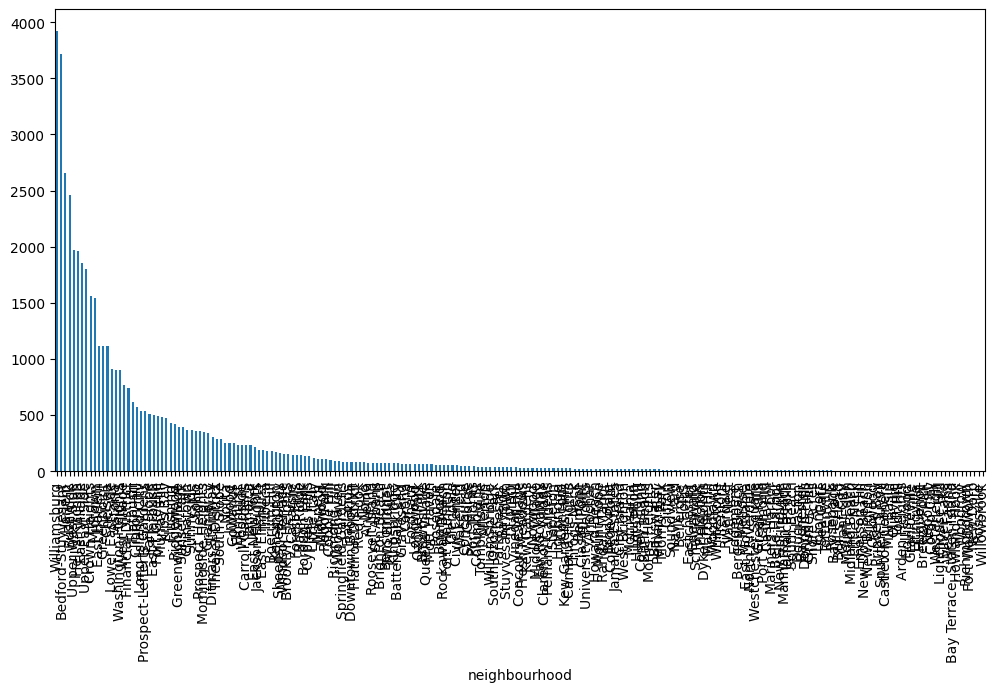

In [167]:
neighbourhood_counts = data['neighbourhood'].value_counts()
neighbourhood_counts.plot(kind='bar', figsize=(12, 6))
plt.show()

In [168]:
total = len(data)
umbral = 0.01  # Umbral en el 1%
neighbourhood_counts = data['neighbourhood'].value_counts()

# Reemplazar los barrios que constituyen menos del umbral de porcentaje
data['neighbourhood'] = data['neighbourhood'].apply(lambda x: 'otros' if (neighbourhood_counts[x] / total) < umbral else x)

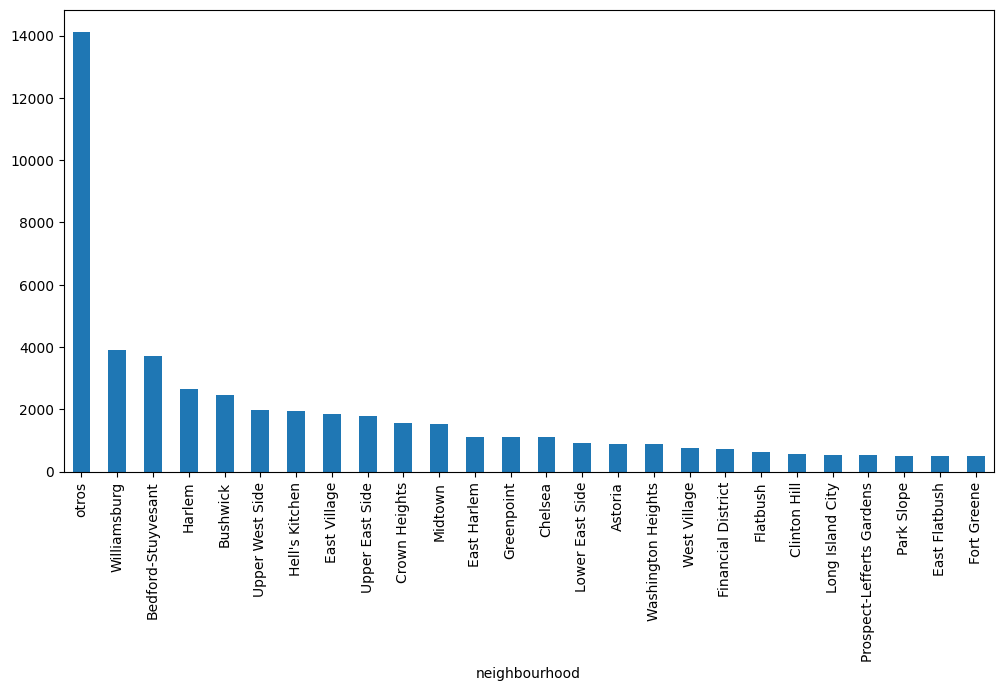

In [169]:
neighbourhood_counts = data['neighbourhood'].value_counts()
neighbourhood_counts.plot(kind='bar', figsize=(12, 6))
plt.show()

In [170]:
data['neighbourhood'].value_counts().sort_values()

neighbourhood
Fort Greene                    489
East Flatbush                  500
Park Slope                     506
Prospect-Lefferts Gardens      535
Long Island City               537
Clinton Hill                   572
Flatbush                       621
Financial District             744
West Village                   768
Washington Heights             899
Astoria                        900
Lower East Side                911
Chelsea                       1113
Greenpoint                    1115
East Harlem                   1117
Midtown                       1545
Crown Heights                 1564
Upper East Side               1798
East Village                  1853
Hell's Kitchen                1958
Upper West Side               1971
Bushwick                      2465
Harlem                        2658
Bedford-Stuyvesant            3714
Williamsburg                  3920
otros                        14122
Name: count, dtype: int64

In [171]:
# plt.figure(figsize=(10, 6))
# sns.countplot(data=d, x='neighbourhood_group', palette='Set2')
# plt.title('Distribución de Neighbourhood Group')
# plt.xlabel('Neighbourhood Group')
# plt.ylabel('Conteo')
# plt.show()

In [172]:
# plt.figure(figsize=(10, 6))
# sns.countplot(data=data, x='room_type', palette='Set3')
# plt.title('Distribución de Room Type')
# plt.xlabel('Room Type')
# plt.ylabel('Conteo')
# plt.show()

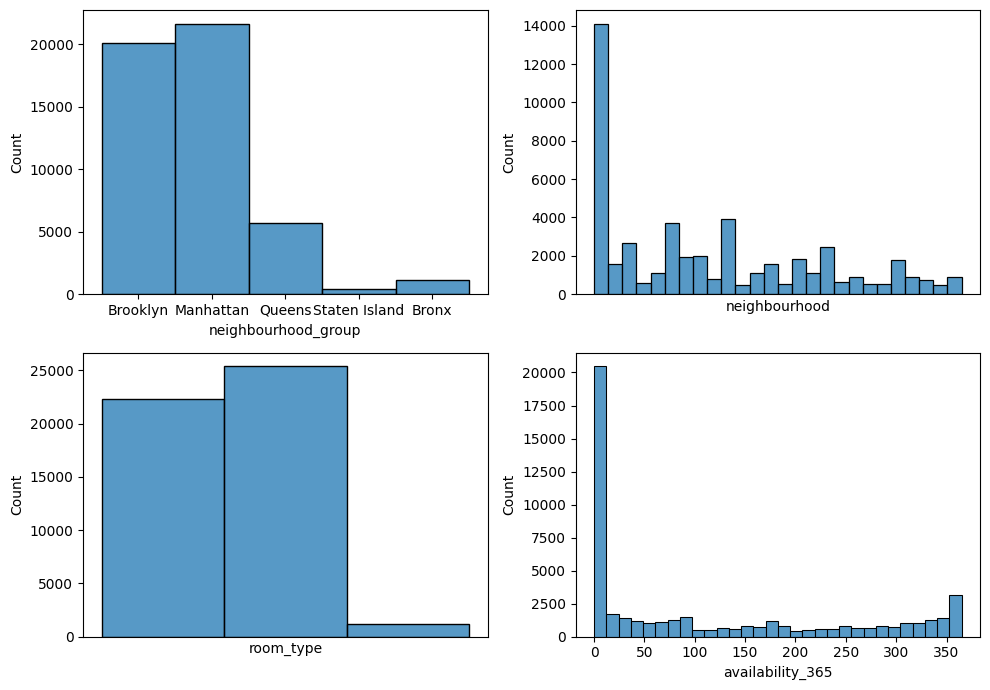

In [173]:
fig, axis = plt.subplots(2, 2, figsize=(10, 7))

sns.histplot(ax = axis[0,0], data = data, x = "neighbourhood_group")
sns.histplot(ax = axis[0,1], data = data, x = "neighbourhood").set_xticks([])
sns.histplot(ax = axis[1,0], data = data, x = "room_type").set_xticks([])
sns.histplot(ax = axis[1,1], data = data, x = "availability_365")

plt.tight_layout()

plt.show()

#### Análisis:
- **neighbourhood**: quitando los valores agrupados en otros, vemos que la mayoría de los alojamientos estan en los barrios de Chelsea, Greenpoint, East Harlem, Midtown, Crown Heights, Upper East Side, East Village, Hell's Kitchen, Upper West Side, Bushwick, Harlem, Bedford-Stuyvesant y Williamsburg, representando más del 50% de los datos. 
- **neighbourhood_group**: para esta variable tenemos 5 categorías, entre las cuales encontramos la mayoría de los datos en 2 de ellas, estas son los barrios de Manhattan y Brooklyn.
- **room_type**: tenemos 3 categorías de tipo de alojamiento, habitación privada, apartamento/casa completo y habitación compartida. La mayoría de los datos se reparte entre las dos primeras categorías mencionadas.
- **Availability_365**: hay muchos 0 para esta categoría, podríamos cambiarlos por valor nulo e imputarlos.

### Análisis sobre variables numéricas: latitude, longitude, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count

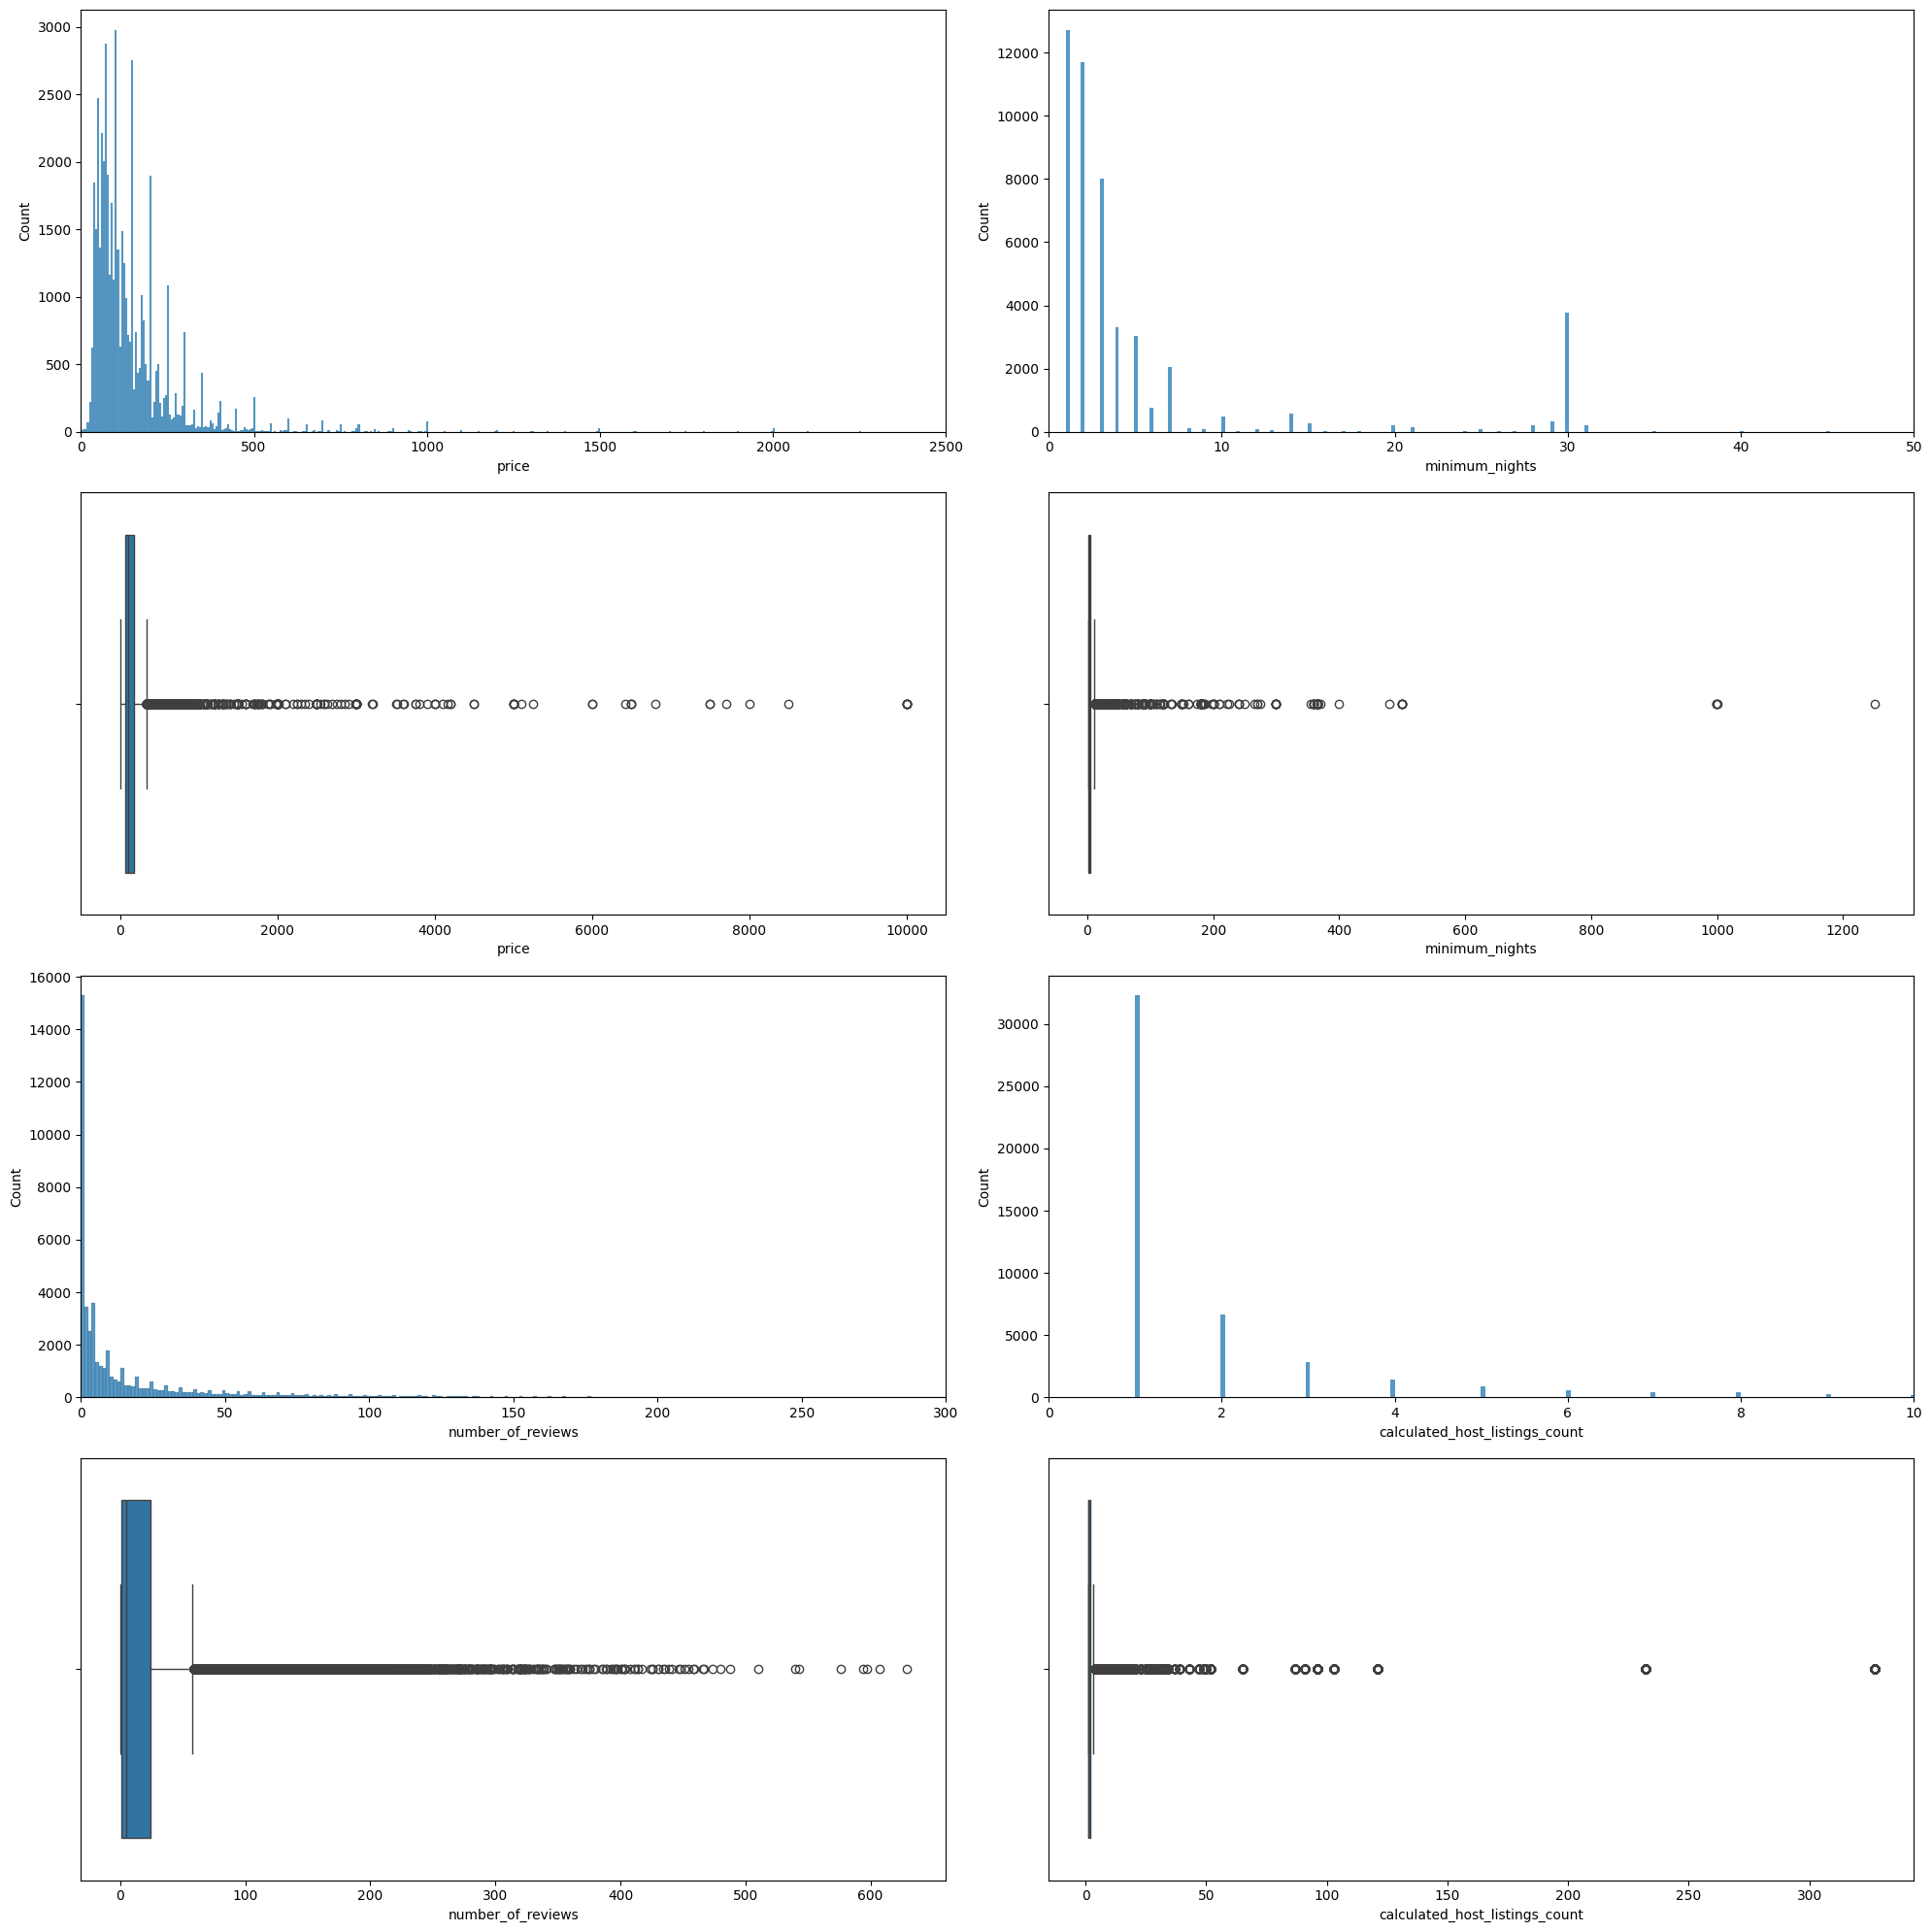

In [174]:
fig, axis = plt.subplots(4, 2, figsize = (20, 20))

sns.histplot(ax = axis[0, 0], data = data, x = "price").set_xlim(0, 2500)
sns.boxplot(ax = axis[1, 0], data = data, x = "price")
sns.histplot(ax = axis[0, 1], data = data, x = "minimum_nights").set_xlim(0, 50)
sns.boxplot(ax = axis[1, 1], data = data, x = "minimum_nights")
sns.histplot(ax = axis[2, 0], data = data, x = "number_of_reviews").set_xlim(0, 300)
sns.boxplot(ax = axis[3, 0], data = data, x = "number_of_reviews")
sns.histplot(ax = axis[2, 1], data = data, x = "calculated_host_listings_count").set_xlim(0, 10)
sns.boxplot(ax = axis[3, 1], data = data, x = "calculated_host_listings_count")

plt.tight_layout()

plt.show()

In [175]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,otros,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


In [176]:
data["price"].sort_values().head(20)

26841     0
25753     0
26866     0
25433     0
26259     0
23161     0
25796     0
25794     0
25634     0
25795     0
25778     0
35601    10
21700    10
33505    10
31407    10
34446    10
24100    10
27972    10
23256    10
22261    10
Name: price, dtype: int64

In [177]:
# # Elimino las filas con precio 0
# data = data[data['price'] != 0]

# Cambio los valores 0 de precio por valores nulos para poder imputarlos
data['price'] = data['price'].replace(0, np.nan)

Podríamos haberlos eliminado directamente porque son solo unos 10 valores nulos pero así practico la imputación con el método k vecinos próximos.

In [178]:
data.isnull().mean()*100

neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.022497
minimum_nights                    0.000000
number_of_reviews                 0.000000
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

In [179]:
imputador_knn = KNNImputer(n_neighbors=3)
data[['price']] = imputador_knn.fit_transform(data[['price']])

In [180]:
data.isnull().mean()*100

neighbourhood_group               0.0
neighbourhood                     0.0
latitude                          0.0
longitude                         0.0
room_type                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
dtype: float64

In [181]:
data['log_price'] = np.log(data.price)

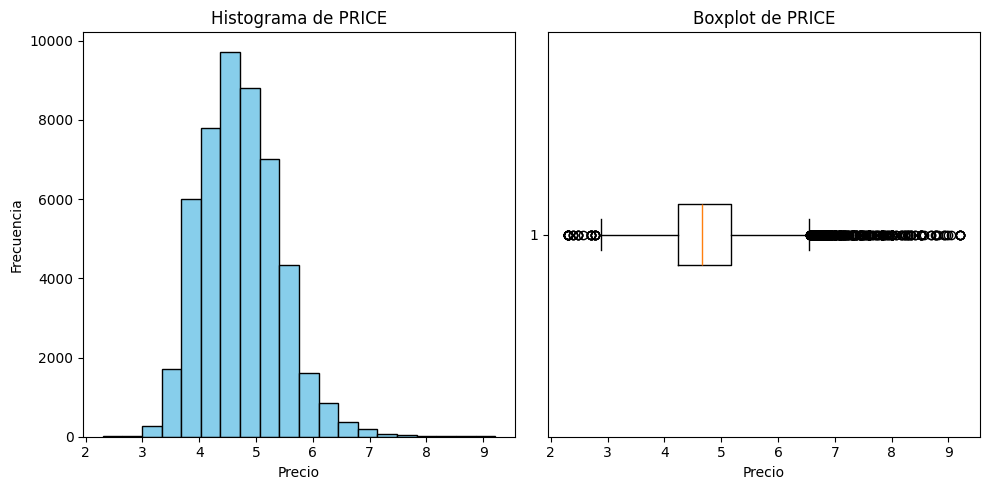

In [182]:
# Crear una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Crear un histograma en el primer subplot
ax[0].hist(data['log_price'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de PRICE')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

# Crear un boxplot en el segundo subplot
ax[1].boxplot(data['log_price'], vert=False)
ax[1].set_title('Boxplot de PRICE')
ax[1].set_xlabel('Precio')

# Mostrar la figura
plt.tight_layout()
plt.show()

In [200]:
data.drop(["price"], axis = 1, inplace = True)# 

La transformación logarítmica puede ayudar a hacer que los datos se ajusten mejor a los supuestos de los modelos estadísticos y mejorar la estabilidad del modelo frente a valores extremos.

Hemos eliminado dos columnas que tenían 20% de valores nulos y ademas no eran relevantes para el modelo. He cambiado los valores de precio 0 a nulos y despues los he imputado.

<Axes: >

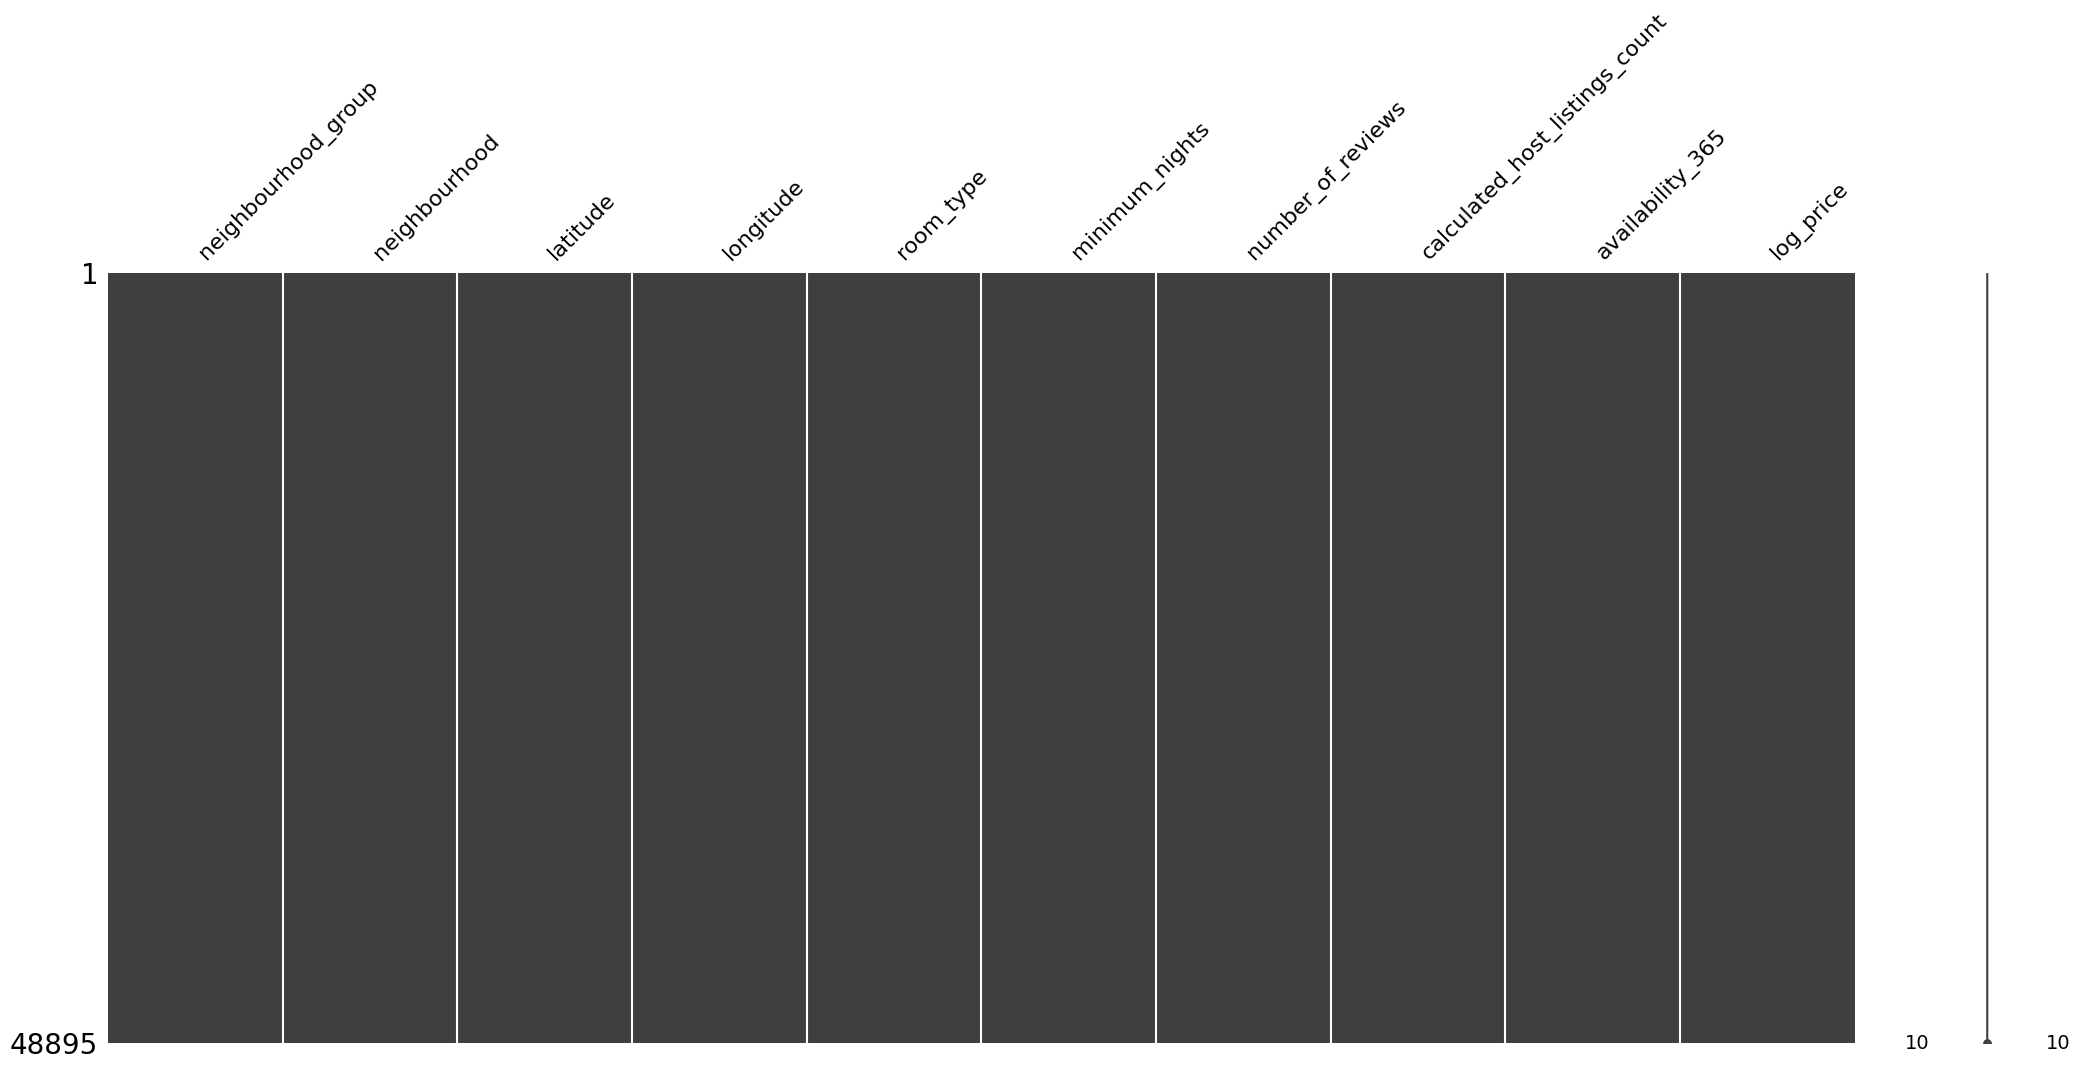

In [149]:
msno.matrix(data) # Esto es para ver si hay relación entre la falta de valores, en el caso de ese dataset no se necesitaría

# Paso 4: Análisis de variables multivariante

## Análisis numérico-numérico

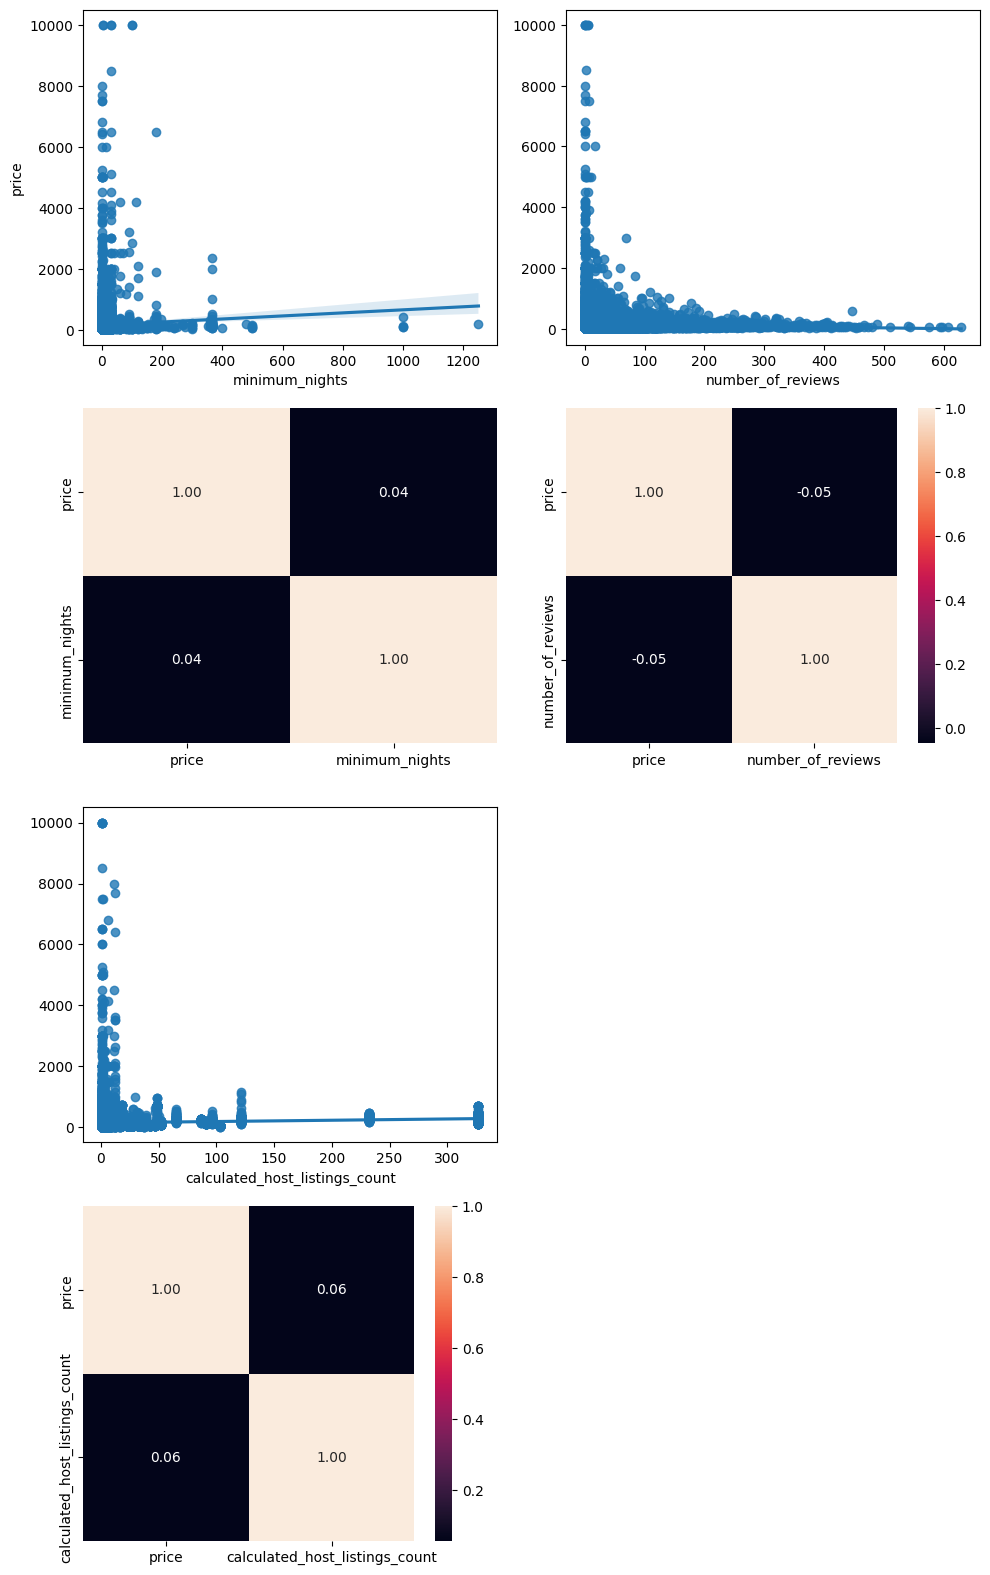

In [183]:

fig, axis = plt.subplots(4, 2, figsize = (10, 16))


sns.regplot(ax = axis[0, 0], data = data, x = "minimum_nights", y = "price")
sns.heatmap(data[["price", "minimum_nights"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)

sns.regplot(ax = axis[0, 1], data = data, x = "number_of_reviews", y = "price").set(ylabel = None)
sns.heatmap(data[["price", "number_of_reviews"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

sns.regplot(ax = axis[2, 0], data = data, x = "calculated_host_listings_count", y = "price").set(ylabel = None)
sns.heatmap(data[["price", "calculated_host_listings_count"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0]).set(ylabel = None)
fig.delaxes(axis[2, 1])
fig.delaxes(axis[3, 1])

plt.tight_layout()

plt.show()

No hay relación remarcable entre las variables minimum_night, number_reviews y calculates_host_listing_count y precio.

## Análisis categórico-categórico: neighbouhood_group vs room_type

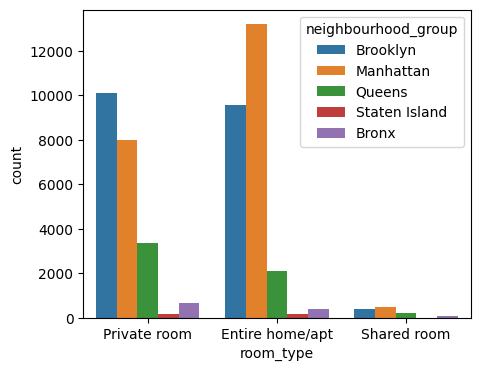

In [184]:
fig, axis = plt.subplots(figsize = (5, 4))

sns.countplot(data = data, x = "room_type", hue = "neighbourhood_group")

plt.show()

Como tenemos variables categóricas cuando queramos hacer el análisis conjunto de las variables categóricas-numéricas no podremos. Primero tenemos que transformas las categóricas en numéricas. Lo hacemos con el métido one-hot

In [191]:
# Creamos las variables binarias
dummies_neighbourhood_group = pd.get_dummies(data['neighbourhood_group'], drop_first = True)

dummies_room_type = pd.get_dummies(data['room_type'], drop_first = True)

# La variable neighbourhood la voy a obviar ya que en neighbouhood_group ya se tiene en cuenta de una manera más general.

,Private room,Shared room
0,True,False
1,False,False
2,True,False
3,False,False
4,False,False


In [192]:
dummies_neighbourhood_group.head()

,Brooklyn,Manhattan,Queens,Staten Island
0,True,False,False,False
1,False,True,False,False
2,False,True,False,False
3,True,False,False,False
4,False,True,False,False


In [193]:
dummies_room_type.head()

,Private room,Shared room
0,True,False
1,False,False
2,True,False
3,False,False
4,False,False


In [194]:
# Añadimos las variables binarias al DataFrame
data = pd.concat([data, dummies_neighbourhood_group], axis = 1)
data = pd.concat([data, dummies_room_type], axis = 1)
# Eliminamos la vairable original race
data = data.drop(columns=['neighbourhood_group'])
data = data.drop(columns=['room_type'])
data = data.drop(columns=['neighbourhood'])

In [195]:
data.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price,Brooklyn,Manhattan,Queens,Staten Island,Private room,Shared room
0,40.64749,-73.97237,149.0,1,9,6,365,5.003946,True,False,False,False,True,False
1,40.75362,-73.98377,225.0,1,45,2,355,5.416100,False,True,False,False,False,False
2,40.80902,-73.94190,150.0,3,0,1,365,5.010635,False,True,False,False,True,False
3,40.68514,-73.95976,89.0,1,270,1,194,4.488636,True,False,False,False,False,False
4,40.79851,-73.94399,80.0,10,9,1,0,4.382027,False,True,False,False,False,False


Primero separación de los datos de entrenamiento (80%) y de prueba (20%)

In [201]:
X = data.drop("log_price", axis = 1)
y = data["log_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [202]:
X_corr = X_train.copy()
X_corr['y'] = y_train
corr = X_corr.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,Brooklyn,Manhattan,Queens,Staten Island,Private room,Shared room,y
latitude,1.000,0.081,0.025,-0.012,0.020,-0.008,-0.673,0.592,0.015,-0.190,-0.002,0.007,0.083
longitude,0.081,1.000,-0.063,0.058,-0.115,0.083,0.020,-0.434,0.623,-0.291,0.186,0.030,-0.327
minimum_nights,0.025,-0.063,1.000,-0.078,0.122,0.141,-0.040,0.069,-0.035,-0.009,-0.072,-0.000,0.033
number_of_reviews,-0.012,0.058,-0.078,1.000,-0.073,0.175,0.016,-0.046,0.036,0.018,0.019,-0.022,-0.045
calculated_host_listings_count,0.020,-0.115,0.122,-0.073,1.000,0.223,-0.124,0.154,-0.035,-0.013,-0.111,-0.011,0.133
availability_365,-0.008,0.083,0.141,0.175,0.223,1.000,-0.080,-0.006,0.088,0.057,-0.011,0.059,0.098
Brooklyn,-0.673,0.020,-0.040,0.016,-0.124,-0.080,1.000,-0.748,-0.301,-0.073,0.083,-0.017,-0.193
Manhattan,0.592,-0.434,0.069,-0.046,0.154,-0.006,-0.748,1.000,-0.322,-0.078,-0.162,-0.009,0.349
Queens,0.015,0.623,-0.035,0.036,-0.035,0.088,-0.301,-0.322,1.000,-0.031,0.104,0.024,-0.186
Staten Island,-0.190,-0.291,-0.009,0.018,-0.013,0.057,-0.073,-0.078,-0.031,1.000,0.008,0.000,-0.046


No hay ninguna variable con influencia determinante.

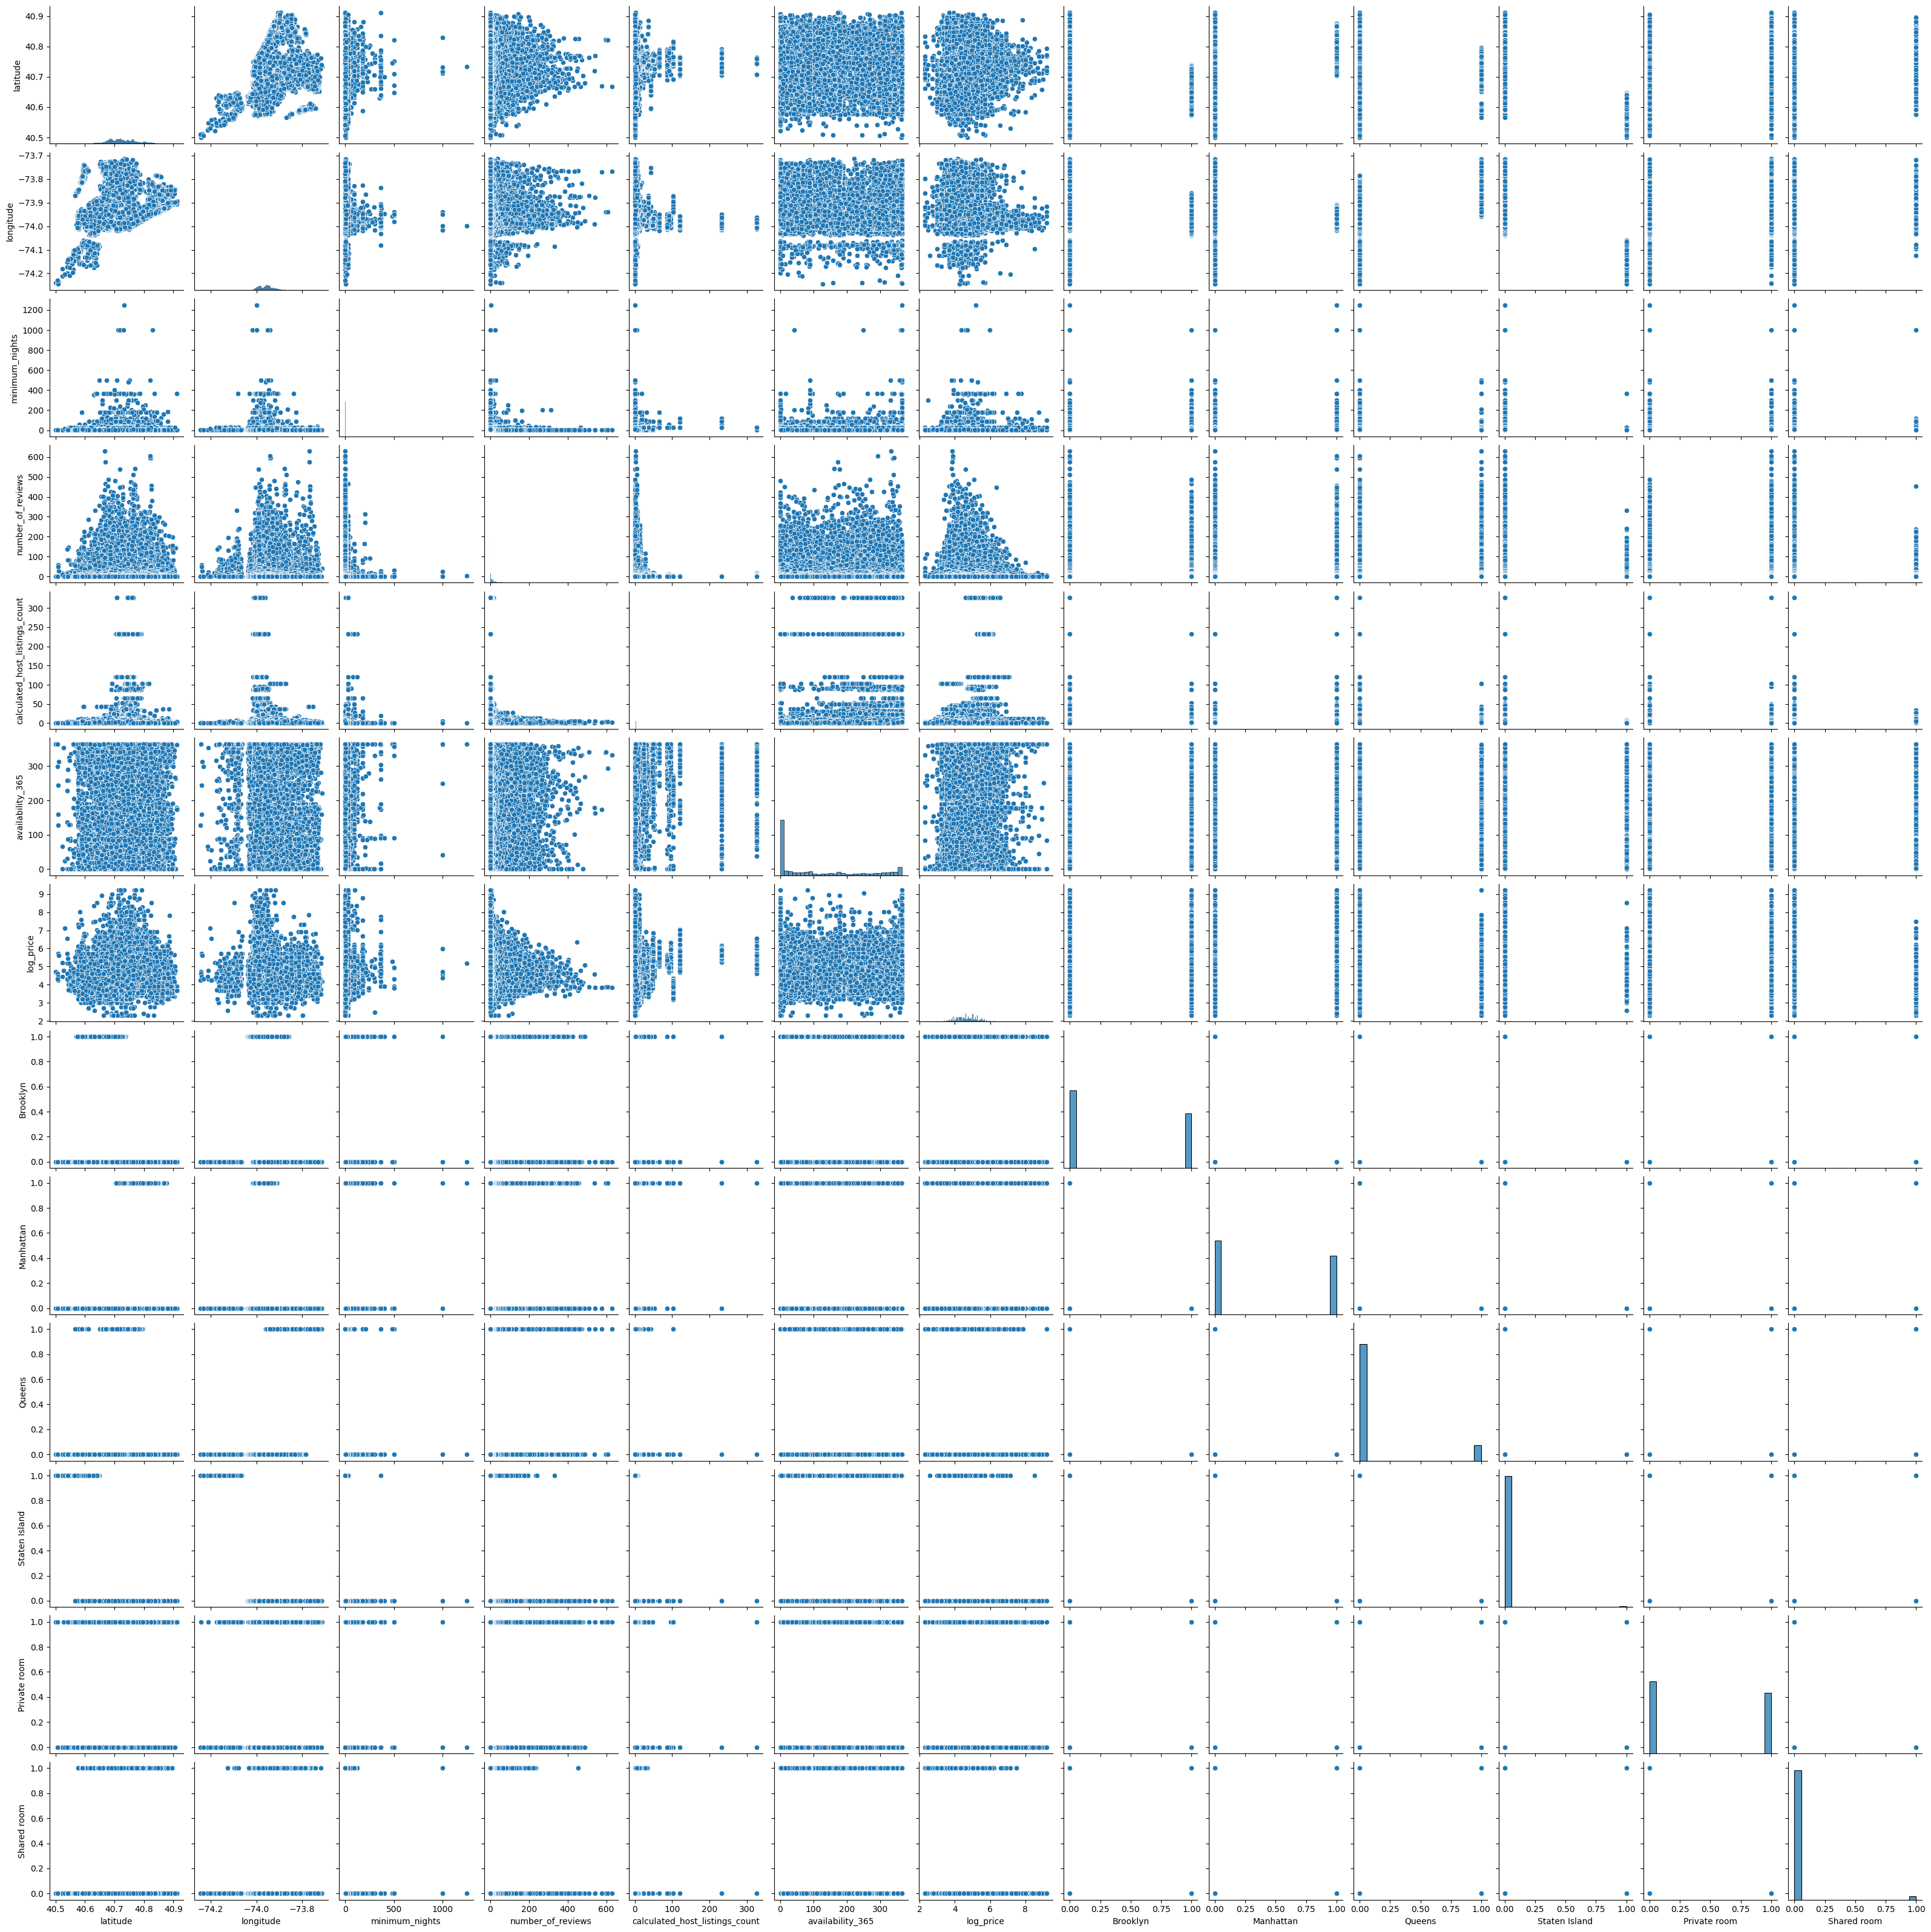

In [203]:
sns.pairplot(data = data)

Para el análisis de valores atípicos en la variable precio he